In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir("../")

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib 
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline

import scipy.stats
from skimage.measure import compare_ssim as ssim
from seisgan.utils import set_seed

import os
import argparse
import logging

import numpy as np
import torch
from torch.autograd import Variable
from torch.optim import Adam

from seisgan.fwi import layers
from seisgan.networks import GeneratorMultiChannel, HalfChannels, HalfChannelsTest
from tqdm import tqdm_notebook as tqdm

def get_kde(data):
    kdea = scipy.stats.gaussian_kde(data)
    return kdea

def mse(x, y):
    return np.linalg.norm(x - y)

def threshold(img):
    return np.where(img > 0.5, 1.0, 0.0)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

def colorbar(mappable, label, vertical, horizontal):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    if label is not None:
        cax.text(horizontal, vertical, label, fontsize=20, rotation=90)
    return fig.colorbar(mappable, cax=cax)

## Load checkpoints and datasets

In [3]:
plot = True 

results_dir = "./results"
case = "results_noise_25"
generator_path = os.path.expandvars("./checkpoints/generator_facies_multichannel_4_6790.pth")
minsmaxs_path = os.path.expandvars("./synthetics/half_circle_facies_vp_rho_mean_std_min_max.npy")
testimgs_path = os.path.expandvars("./synthetics/test_half_circle_facies_vp_rho.npy")

tn = lambda n: n.data.cpu().numpy()

generator = GeneratorMultiChannel()
new_state_dict = torch.load(generator_path)
generator.load_state_dict(new_state_dict)
generator.cpu()
generator.eval()

minsmaxs = np.load(minsmaxs_path)

half_channel_gen = HalfChannels(generator, min_vp=minsmaxs[2, 1], max_vp=minsmaxs[3, 1], vp_bottom=1.8, vp_top=1.8)
half_channel_test = HalfChannelsTest(min_vp=minsmaxs[2, 1], max_vp=minsmaxs[3, 1], vp_bottom=1.8, vp_top=1.8)

x_gt = torch.from_numpy(np.load(testimgs_path)[0]).float().unsqueeze(0)
x_gt, x_geo_gt = half_channel_test(x_gt)

In [4]:
def load_data(run, num_runs=100):
    half_channel_gen.cuda()
    losses = []
    for i in range(100):
        losses.append(np.load("./results/"+case+"/"+run+"/test_"+str(i)+"/test_"+str(i)+"_"+str(i)+"_losses_0.npy"))
    losses = np.array(losses)

    latents = []
    for i in range(100):
        latents.append(np.load("./results/"+case+"/"+run+"/test_"+str(i)+"/test_"+str(i)+"_"+str(i)+"_latents_0.npy")[:, 0])
    latents = np.array(latents)
    
    imgs, vps = [], []
    for latent in tqdm(latents):
        latents_th = torch.from_numpy(latent).cuda()
        with torch.no_grad():
            vp, x = half_channel_gen(latents_th)
        imgs.append(tn(x))
        vps.append(tn(vp)[0])     
        
    
    imgs = np.array(imgs) 
    
    imgs[:, :, [0, 1]] = (imgs[:, :, [0, 1]]+1)/2.
    
    vps = np.array(vps)
    return losses, imgs[:, [0, -1]], vps[:, [0, -1]], imgs[:, -1, 0].std(0), imgs[:, -1, 0].mean(0)

In [5]:
losses_2, imgs_2, vps_2, error_bars_2, means_2 = load_data("results_2_sources")
losses_2w, imgs_2w, vps_2w, error_bars_2w, means_2w = load_data("results_2_sources_1_well")
losses_3, imgs_3, vps_3, error_bars_3, means_3 = load_data("results_3_sources")
losses_9, imgs_9, vps_9, error_bars_9, means_9 = load_data("results_9_sources")
losses_27, imgs_27, vps_27, error_bars_27, means_27 = load_data("results_27_sources")

In [6]:
print(losses_2.shape, imgs_2.shape, vps_2.shape, error_bars_2.shape)

(100, 200, 10) (100, 2, 3, 64, 128) (100, 2, 128, 128) (64, 128)


## Generate models from the prior

In [7]:
half_channel_gen.cpu()
with torch.no_grad():
    latents_prior = torch.randn(100, 50, 1, 2).float().cpu()
    x_gt, x_geo_gt = half_channel_gen(latents_prior)
prior_models = tn(x_geo_gt)
prior_models[:, [0, 1]] = (prior_models[:, [0, 1]]+1)/2.
latents_prior = latents_prior.numpy()
error_bars_prior = prior_models[:, 0].std(0)
means_prior = prior_models[:, 0].mean(0)
print(error_bars_prior.shape)

(64, 128)


## Load test set and plot mean and standard deviation of inferred models

In [8]:
test_set = np.load("./synthetics/test_half_circle_facies_vp_rho.npy")

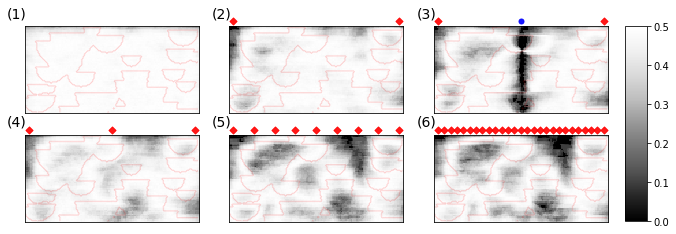

In [9]:
x_gt = torch.from_numpy(test_set[0]).float().unsqueeze(0)
x_gt_facies = x_gt
x_gt, x_geo_gt = half_channel_test(x_gt)
x_gt_img = tn(x_geo_gt)[0]

fig, axarr = plt.subplots(2, 3, figsize=(12, 12))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.175, hspace=-0.8)
for error_bar, ax, title, shots, wells, prior in zip([error_bars_prior, error_bars_2, error_bars_2w, 
                                    error_bars_3, error_bars_9, error_bars_27], 
                         axarr.flatten(),
                        ["(1)", "(2)", "(3)", "(4)", "(5)", "(6)"], [2, 2, 2, 3, 9, 27],
                        [None, None, 64, None, None, None], [True, False, False, False, False, False]):
    
    cax1 = ax.imshow(error_bar, vmin=0.0, vmax=0.5, cmap="Greys_r")
    
    ax.set_title(title, fontsize=14, loc="left", x=-0.1, y=1.03)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.contour(x_gt_img[0], colors="r", linewidths=(0.1, ), alpha=0.25)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("top", size="10%", pad=0.01)
    if prior:
        cax.scatter(np.linspace(2, 126, shots), np.zeros((shots)), s=25, c='red', marker='D', alpha=0.0)
    else:
        cax.scatter(np.linspace(2, 126, shots), np.zeros((shots)), s=25, c='red', marker='D', alpha=0.9)
    cax.set_axis_off()
    cax.set_xlim(-1, 129)
    if wells is not None:
        cax.scatter(wells, 0, s=25, c='blue', marker='o', alpha=0.9)
    else:
        cax.scatter(wells, 0, s=25, c='blue', marker='o', alpha=0.9)
        
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.385, 0.025, 0.225])
fig.colorbar(cax1, cax=cbar_ax)
if plot:
    fig.savefig("./results/figures/error_bars.png", bbox_inches="tight", dpi=300)

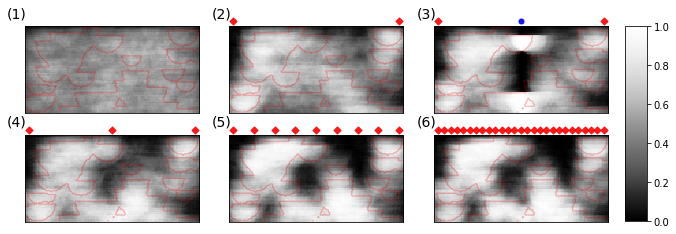

In [35]:
fig, axarr = plt.subplots(2, 3, figsize=(12, 12))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.175, hspace=-0.8)
for error_bar, ax, title, shots, wells, prior in zip([means_prior, means_2, means_2w, 
                                                      means_3, means_9, means_27], 
                         axarr.flatten(),
                        ["(1)", "(2)", "(3)", "(4)", "(5)", "(6)"], [2, 2, 2, 3, 9, 27],
                        [None, None, 64, None, None, None], [True, False, False, False, False, False]):
    cax1 = ax.imshow(error_bar, vmin=0, vmax=1, cmap="Greys_r")
    
    ax.set_title(title, fontsize=14, loc="left", x=-0.1, y=1.03)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.contour(x_gt_img[0], colors="r", linewidths=(0.1, ), alpha=0.5)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("top", size="10%", pad=0.01)
    if prior:
        cax.scatter(np.linspace(2, 126, shots), np.zeros((shots)), s=25, c='red', marker='D', alpha=0.0)
    else:
        cax.scatter(np.linspace(2, 126, shots), np.zeros((shots)), s=25, c='red', marker='D', alpha=0.9)
    cax.set_axis_off()
    cax.set_xlim(-1, 129)
    if wells is not None:
        cax.scatter(wells, 0, s=25, c='blue', marker='o', alpha=0.9)
    else:
        cax.scatter(wells, 0, s=25, c='blue', marker='o', alpha=0.9)
        
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.385, 0.025, 0.225])
fig.colorbar(cax1, cax=cbar_ax)
if plot:
    fig.savefig("./results/figures/means.png", bbox_inches="tight", dpi=300)

## Plot Squared Error Ratio for each scenario

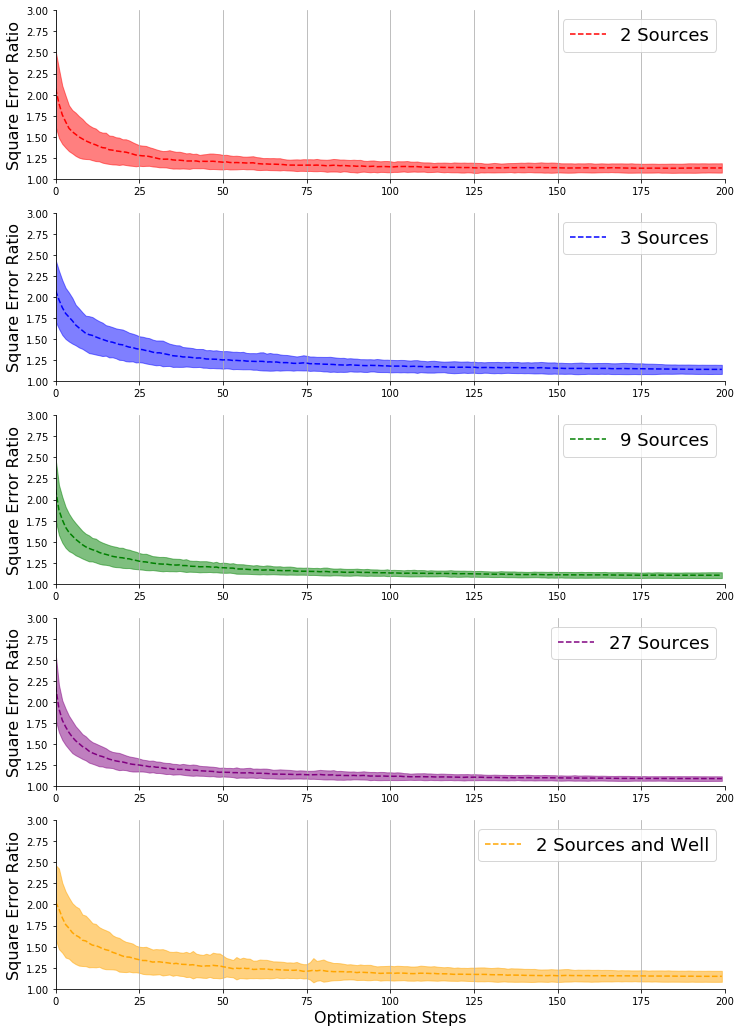

In [11]:
fig, axarr = plt.subplots(5, 1, figsize=(12, 18), sharex=True)
for i, (ax, loss, color, label, target) in enumerate(zip(axarr, [losses_2, losses_3, losses_9, losses_27, losses_2w], 
                          ["red", "blue", "green", "purple", "orange", "grey"],
                          ["2 Sources", "3 Sources", "9 Sources", "27 Sources", "2 Sources and Well"],
                          [0.1, 0.1, 0.1, 0.1, 0.1])):
    idx_square_error_norm, noise_square_error_norm = 2, 5
    if i == 4:
        idx_square_error_norm = 5
        noise_square_error_norm = 8
        
    squared_error_ratio = (loss[:, :, idx_square_error_norm]/loss[:, :, noise_square_error_norm].mean()).astype(np.float32)
    
    avg = squared_error_ratio.mean(0)
    std = squared_error_ratio.std(0)
    upper, lower = avg+std, avg-std
    
    ax.plot(avg, color=color, linestyle="--", label=label)
    ax.fill_between(range(200), upper, lower, alpha=0.5, color=color)
    ax.set_xlim(0, 200)
    ax.set_ylim(1.0, 3.0)
    ax.legend(fontsize=18)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.grid()
    #ax.axhline(target, linestyle="-.", alpha=0.5, linewidth=0.5, color="black")
    ax.set_ylabel("Square Error Ratio", fontsize=16)
    
axarr[-1].set_xlabel("Optimization Steps", fontsize=16)
if plot:
    fig.savefig("./results/figures/convergence.png", bbox_inches="tight", dpi=300)

## Plot a reference wavefield for three sources and show residual

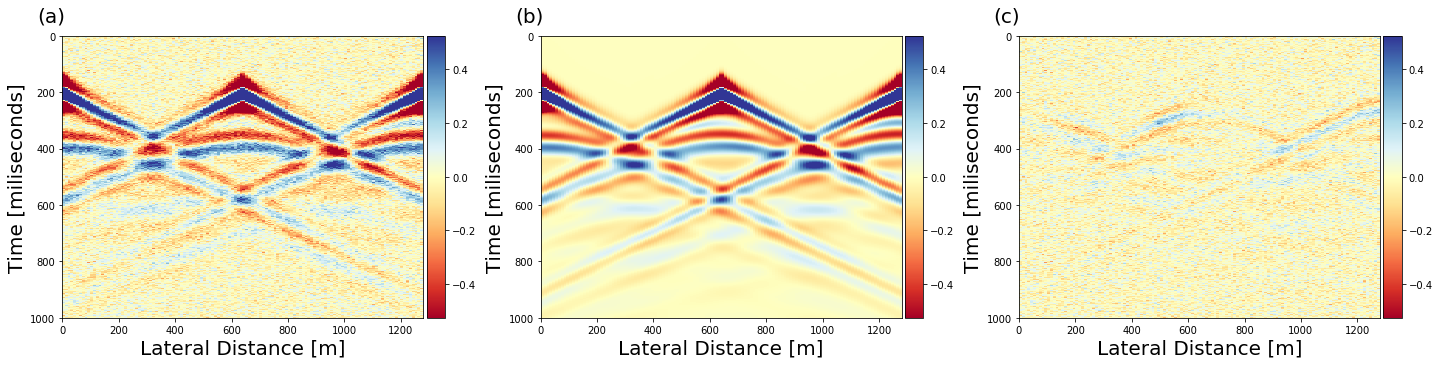

In [12]:
ground_truth_shots = np.load("./results/"+case+"/results_3_sources_all/test_0/test_0_0_shots_gt.npy")
reconstruction_shots = np.load("./results/"+case+"/results_3_sources_all/test_0/test_0_0_shots_0.npy")

def colorbar(mappable, label, vertical, horizontal):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cax.text(horizontal, vertical, label, fontsize=16, rotation=90)
    return fig.colorbar(mappable, cax=cax)

vmin = -2*np.std(ground_truth_shots)
vmax = 2*np.std(ground_truth_shots)
fig, axarr = plt.subplots(1, 3, figsize=(24, 12))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=-0.6)
for error_bar, ax, title, label, vert, h in zip([ground_truth_shots, reconstruction_shots, ground_truth_shots-reconstruction_shots], 
                         axarr.flatten(),
                        ["(a)", "(b)", "(c)"], 
                                           ["Amplitude [-]", "Amplitude [-]", "Amplitude Difference [-]"],
                                                  [-0.15, -0.15, -0.3],
                                                        [3, 3, 3.]):
    cax1 = ax.imshow(error_bar[::-1], cmap="RdYlBu", extent=[0, 128*10, 0, 1000], vmin=vmin, vmax=vmax)
    colorbar(cax1, None, vert, h)
    ax.set_title(title, fontsize=20, loc="left", x=-0.07, y=1.03)
    ax.set_ylim(1000, 0)
    ax.set_xlabel("Lateral Distance [m]", fontsize=20)
    ax.set_ylabel("Time [miliseconds]", fontsize=20)

if plot:
    fig.savefig("./results/figures/comparison_waveforms.png", bbox_inches="tight", dpi=300)

## Plot models from the prior, 2, 3, 9, 27 sources and 2 sources+1 well

1.613519252650085 2.9139526530720925 2.0716220065365825 2.3155332250619165


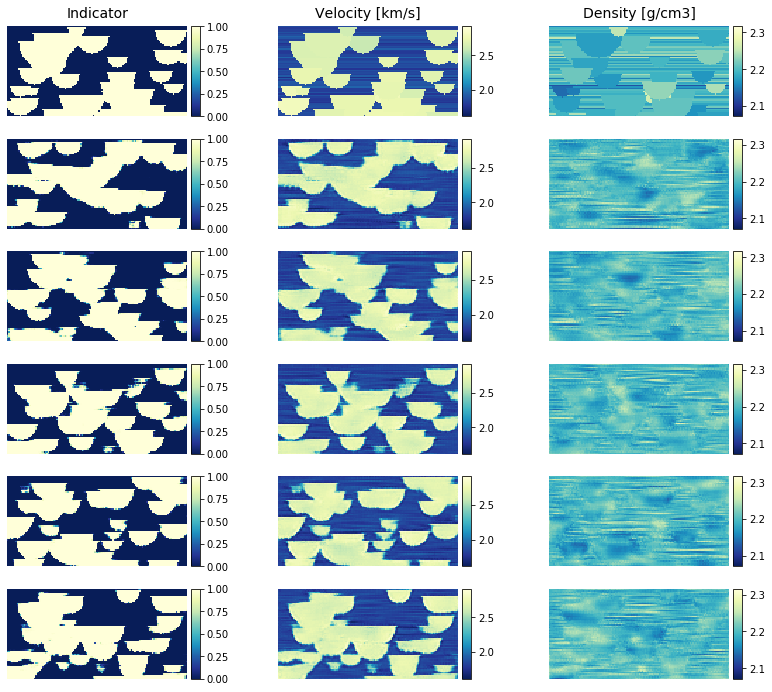

In [13]:
x_gt = torch.from_numpy(test_set[0]).float().unsqueeze(0)
x_gt_facies = x_gt
x_gt, x_geo_gt = half_channel_test(x_gt)
x_gt_img = tn(x_geo_gt)[0]

vp_min = minsmaxs[2, 1]

vp_max = minsmaxs[3, 1]
rho_min = minsmaxs[2, 2]
rho_max = minsmaxs[3, 2]
print(vp_min, vp_max, rho_min, rho_max)

fig, axcol = plt.subplots(6, 3, figsize=(24, 12))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=-0.66, hspace=0.25)
models = imgs_2[:, -1]
for i, axarr, model in zip(range(6), axcol[:], [x_gt_img, *models[0:5]]):
    for error_bar, ax, title, vmin, vmax, label, vert, h in zip([model[0], model[1], model[2]], 
                             axarr.flatten(),
                            ["(a)", "(b)", "(c)"],
                                               [0, vp_min, rho_min], [1, vp_max, rho_max], 
                                               ["Indicator", "Velocity [km/s]", "Density [g/cm3]"],
                                                      [0.65, 0.75, 0.75],
                                                            [2.5, 2.75, 3.]):
        
        if i == 0:
            cax1 = ax.imshow(error_bar*(vmax-vmin)+vmin, cmap="YlGnBu_r", vmin=vmin, vmax=vmax)
            colorbar(cax1, None, vert, h)
            ax.set_title(label, fontsize=14, y=1.03)
        else:
            cax1 = ax.imshow(error_bar*(vmax-vmin)+vmin, cmap="YlGnBu_r", vmin=vmin, vmax=vmax)
            colorbar(cax1, None, vert, h)
        ax.set_axis_off()
        
if plot:
    fig.savefig("./results/figures/models_2.png", bbox_inches="tight", dpi=300)

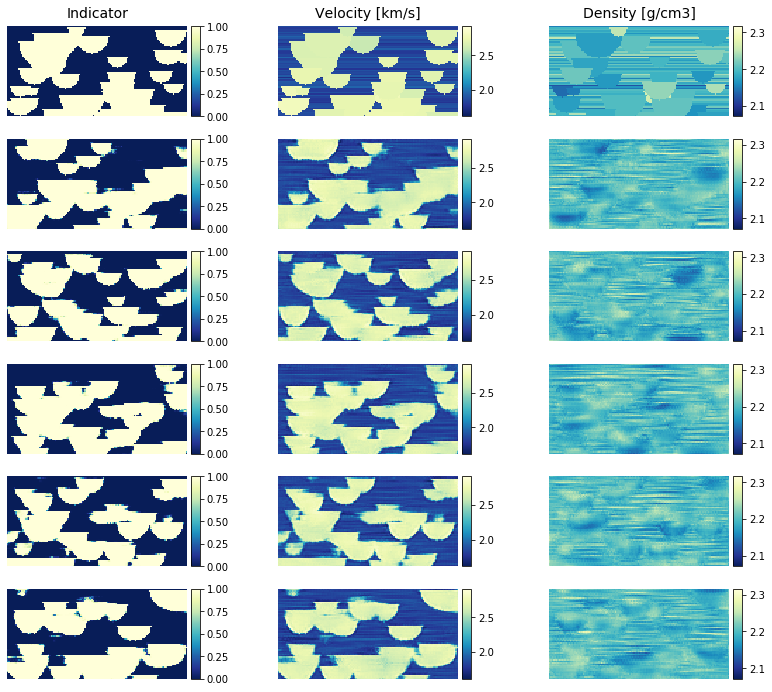

In [14]:
fig, axcol = plt.subplots(6, 3, figsize=(24, 12))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=-0.66, hspace=0.25)
models = imgs_3[:, -1]
for i, axarr, model in zip(range(6), axcol[:], [x_gt_img, *models[0:5]]):
    for error_bar, ax, title, vmin, vmax, label, vert, h in zip([model[0], model[1], model[2]], 
                             axarr.flatten(),
                            ["(a)", "(b)", "(c)"],
                                               [0, vp_min, rho_min], [1, vp_max, rho_max], 
                                               ["Indicator", "Velocity [km/s]", "Density [g/cm3]"],
                                                      [0.65, 0.75, 0.75],
                                                            [2.5, 2.75, 3.]):
        
        if i == 0:
            cax1 = ax.imshow(error_bar*(vmax-vmin)+vmin, cmap="YlGnBu_r", vmin=vmin, vmax=vmax)
            colorbar(cax1, None, vert, h)
            ax.set_title(label, fontsize=14, y=1.03)
        else:
            cax1 = ax.imshow(error_bar*(vmax-vmin)+vmin, cmap="YlGnBu_r", vmin=vmin, vmax=vmax)
            colorbar(cax1, None, vert, h)
        ax.set_axis_off()
if plot:        
    fig.savefig("./results/figures/models_3.png", bbox_inches="tight", dpi=300)

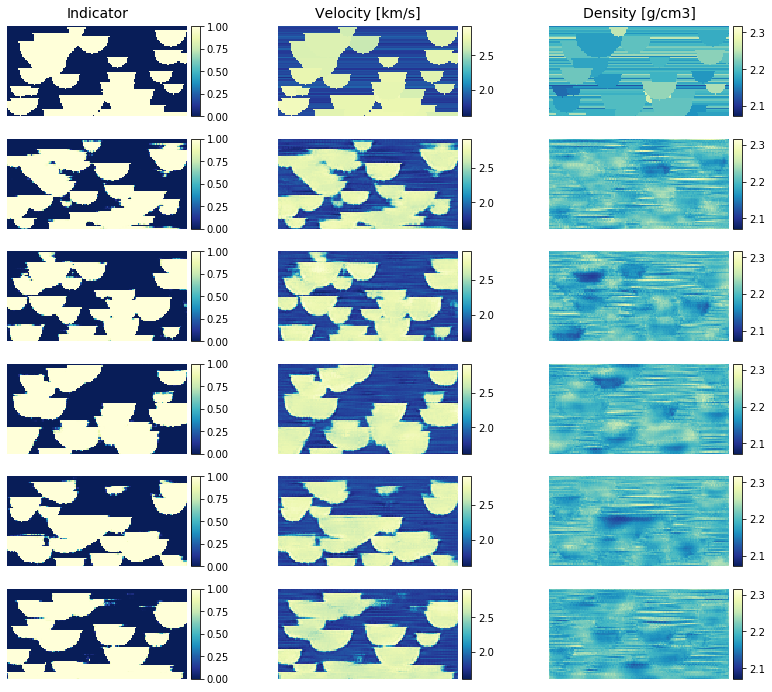

In [15]:
fig, axcol = plt.subplots(6, 3, figsize=(24, 12))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=-0.66, hspace=0.25)
models = imgs_9[:, -1]
for i, axarr, model in zip(range(6), axcol[:], [x_gt_img, *models[0:5]]):
    for error_bar, ax, title, vmin, vmax, label, vert, h in zip([model[0], model[1], model[2]], 
                             axarr.flatten(),
                            ["(a)", "(b)", "(c)"],
                                               [0, vp_min, rho_min], [1, vp_max, rho_max], 
                                               ["Indicator", "Velocity [km/s]", "Density [g/cm3]"],
                                                      [0.65, 0.75, 0.75],
                                                            [2.5, 2.75, 3.]):
        
        if i == 0:
            cax1 = ax.imshow(error_bar*(vmax-vmin)+vmin, cmap="YlGnBu_r", vmin=vmin, vmax=vmax)
            colorbar(cax1, None, vert, h)
            ax.set_title(label, fontsize=14, y=1.03)
        else:
            cax1 = ax.imshow(error_bar*(vmax-vmin)+vmin, cmap="YlGnBu_r", vmin=vmin, vmax=vmax)
            colorbar(cax1, None, vert, h)
        ax.set_axis_off()
if plot:        
    fig.savefig("./results/figures/models_9.png", bbox_inches="tight", dpi=300)

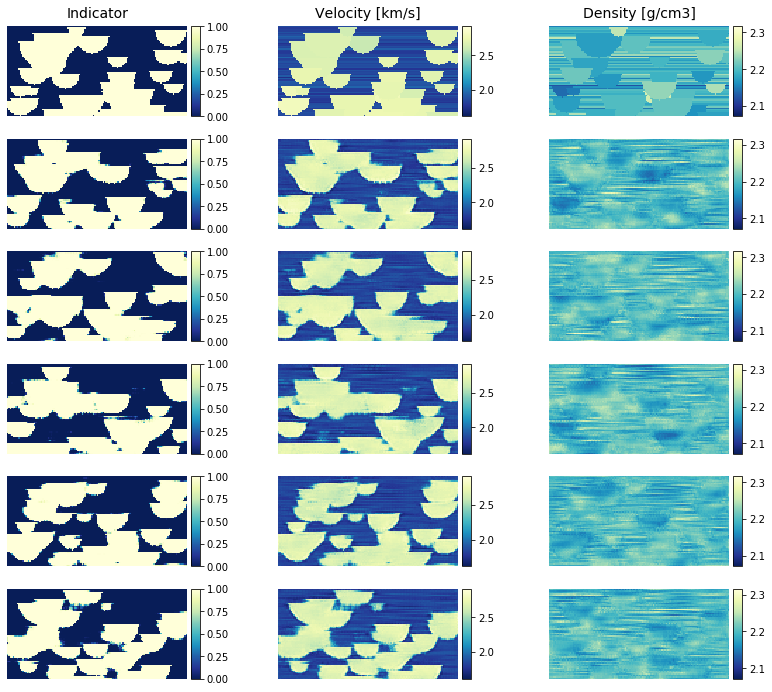

In [16]:
fig, axcol = plt.subplots(6, 3, figsize=(24, 12))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=-0.66, hspace=0.25)
models = imgs_27[:, -1]
for i, axarr, model in zip(range(6), axcol[:], [x_gt_img, *models[0:5]]):
    for error_bar, ax, title, vmin, vmax, label, vert, h in zip([model[0], model[1], model[2]], 
                             axarr.flatten(),
                            ["a)", "b)", "c)"],
                                               [0, vp_min, rho_min], [1, vp_max, rho_max], 
                                               ["Indicator", "Velocity [km/s]", "Density [g/cm3]"],
                                                      [0.65, 0.75, 0.75],
                                                            [2.5, 2.75, 3.]):
        
        if i == 0:
            cax1 = ax.imshow(error_bar*(vmax-vmin)+vmin, cmap="YlGnBu_r", vmin=vmin, vmax=vmax)
            colorbar(cax1, None, vert, h)
            ax.set_title(label, fontsize=14, y=1.03)
        else:
            cax1 = ax.imshow(error_bar*(vmax-vmin)+vmin, cmap="YlGnBu_r", vmin=vmin, vmax=vmax)
            colorbar(cax1, None, vert, h)
        ax.set_axis_off()
        
if plot:        
    fig.savefig("./results/figures/models_27.png", bbox_inches="tight", dpi=300)

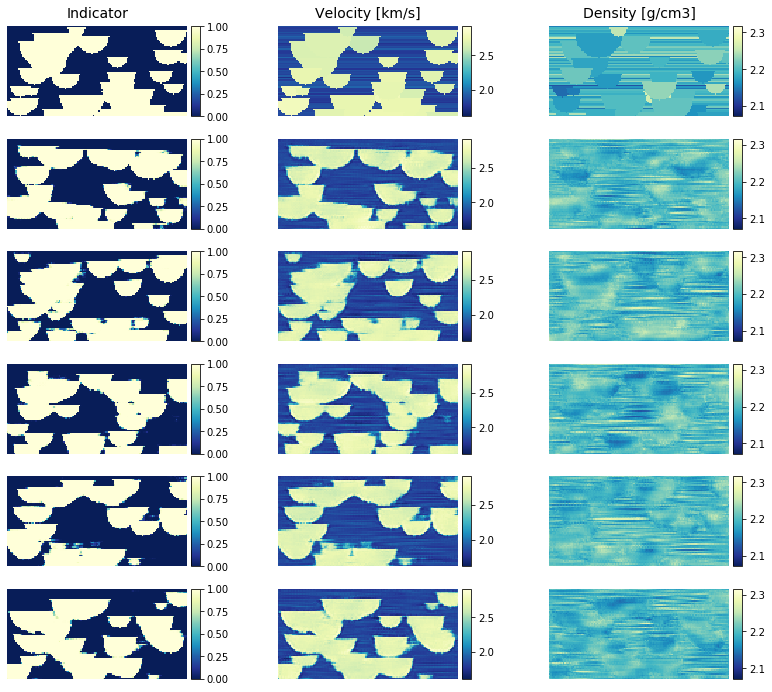

In [17]:
fig, axcol = plt.subplots(6, 3, figsize=(24, 12))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=-0.66, hspace=0.25)
models = imgs_2w[:, -1]
for i, axarr, model in zip(range(6), axcol[:], [x_gt_img, *models[0:5]]):
    for error_bar, ax, title, vmin, vmax, label, vert, h in zip([model[0], model[1], model[2]], 
                             axarr.flatten(),
                            ["a)", "b)", "c)"],
                                               [0, vp_min, rho_min], [1, vp_max, rho_max], 
                                               ["Indicator", "Velocity [km/s]", "Density [g/cm3]"],
                                                      [0.65, 0.75, 0.75],
                                                            [2.5, 2.75, 3.]):
        
        if i == 0:
            cax1 = ax.imshow(error_bar*(vmax-vmin)+vmin, cmap="YlGnBu_r", vmin=vmin, vmax=vmax)
            colorbar(cax1, None, vert, h)
            ax.set_title(label, fontsize=14, y=1.03)
        else:
            cax1 = ax.imshow(error_bar*(vmax-vmin)+vmin, cmap="YlGnBu_r", vmin=vmin, vmax=vmax)
            colorbar(cax1, None, vert, h)
        ax.set_axis_off()
      
if plot:        
    fig.savefig("./results/figures/models_2w.png", bbox_inches="tight", dpi=300)

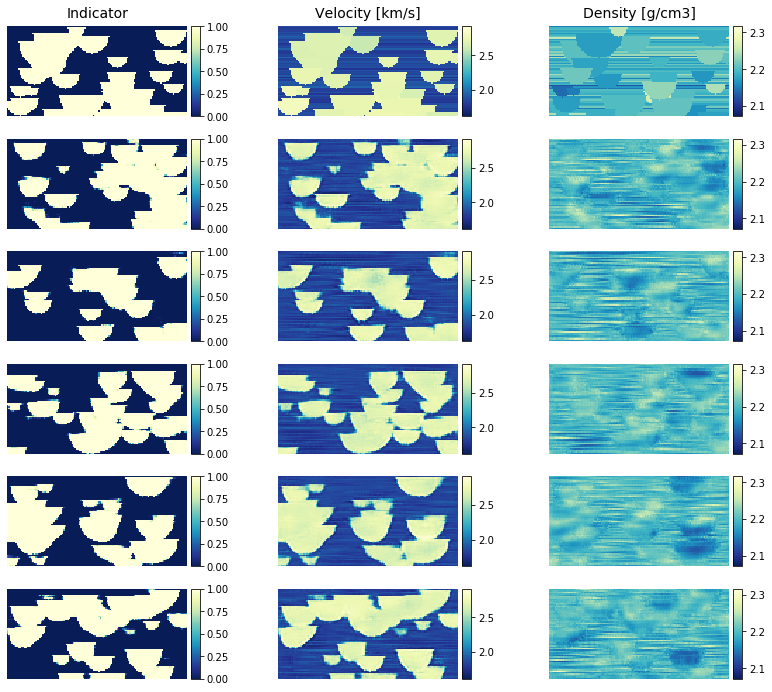

In [18]:
fig, axcol = plt.subplots(6, 3, figsize=(24, 12))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=-0.66, hspace=0.25)
models = prior_models
for i, axarr, model in zip(range(6), axcol[:], [x_gt_img, *models[0:5]]):
    for error_bar, ax, title, vmin, vmax, label, vert, h in zip([model[0], model[1], model[2]], 
                             axarr.flatten(),
                            ["a)", "b)", "c)"],
                                               [0, vp_min, rho_min], [1, vp_max, rho_max], 
                                               ["Indicator", "Velocity [km/s]", "Density [g/cm3]"],
                                                      [0.65, 0.75, 0.75],
                                                            [2.5, 2.75, 3.]):
        
        if i == 0:
            cax1 = ax.imshow(error_bar*(vmax-vmin)+vmin, cmap="YlGnBu_r", vmin=vmin, vmax=vmax)
            colorbar(cax1, None, vert, h)
            ax.set_title(label, fontsize=14, y=1.03)
        else:
            cax1 = ax.imshow(error_bar*(vmax-vmin)+vmin, cmap="YlGnBu_r", vmin=vmin, vmax=vmax)
            colorbar(cax1, None, vert, h)
        ax.set_axis_off()
      
if plot:        
    fig.savefig("./results/figures/models_prior.png", bbox_inches="tight", dpi=300)

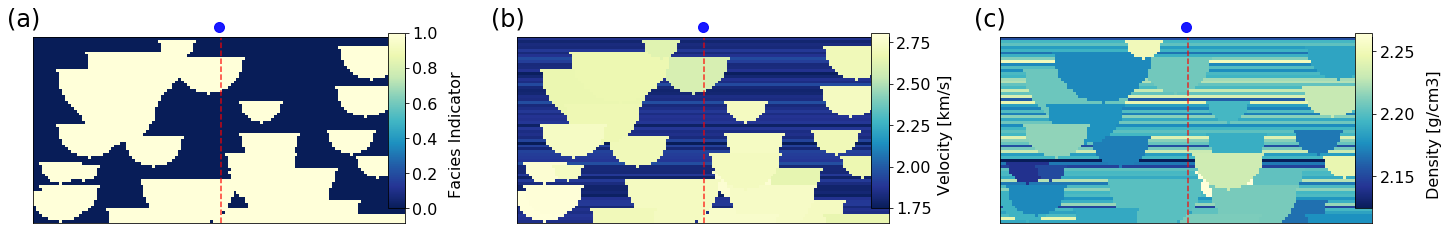

In [19]:
fig, axarr = plt.subplots(1, 3, figsize=(24, 12))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=-0.6)

for error_bar, ax, title, vmin, vmax, label, vert, h in zip([x_gt_img[0], x_gt_img[1], x_gt_img[2]], 
                         axarr.flatten(),
                        ["(a)", "(b)", "(c)"],
                        [0, vp_min, rho_min], [1, vp_max, rho_max], 
                        ["Facies Indicator", "Velocity [km/s]", "Density [g/cm3]"],
                        [0.08, 1.85, 2.135],
                        [3.5, 5.8, 2.7]):
    
    cax1 = ax.imshow(error_bar*(vmax-vmin)+vmin, cmap="YlGnBu_r")
    cb = colorbar(cax1, label, vert, h)
    cb.ax.tick_params(labelsize=16)
    ax.set_title(title, fontsize=24, loc="left", x=-0.07, y=1.03)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axvline(64, color="red", linestyle="--", alpha=0.8)

    divider = make_axes_locatable(ax)
    
    cax = divider.append_axes("top", size="10%", pad=0.01)
    cax.scatter(64, -5, s=100, c='blue', marker='o', alpha=0.9)
    cax.set_axis_off()
    cax.set_xlim(-1, 129)
    
if plot:        
    fig.savefig("./results/figures/ground_truth_overview.png", bbox_inches="tight", dpi=300)

## Similarity Check of Reference Model with Training Images, Prior, and inferred models

In [20]:
ssims_all_mean = 0.11158978556125776

In [21]:
set_seed(42)

half_channel_gen.cuda()
smallest_mse = np.inf
highest_ssim = 0.0
ssim_model, mse_model = None, None
mean_prior_model = None
mses_all, ssims_all = [], []
mean_difference = np.inf
closest_mean_estimate = np.inf
for i in tqdm(range(50)):
    with torch.no_grad():
        latents_prior = torch.randn(1000, 50, 1, 2).float().cuda()
        x_gt, x_geo_gt = half_channel_gen(latents_prior)
    prior_models_check = tn(x_geo_gt)
    prior_models_check[:, [0]] = np.where((prior_models_check[:, [0]]+1)/2.>0.5, 1, 0)
    ssims = [ssim(model[0], x_gt_img[0]) for model in prior_models_check]
    mses = [mse(model[0], x_gt_img[0]) for model in prior_models_check]
    ssims_all += ssims
    mses_all += mses
    
    ssim_max_idx = np.argmax(ssims)
    ssim_max = ssims[ssim_max_idx]
    if ssim_max > highest_ssim:
        ssim_model = prior_models_check[ssim_max_idx][0]
        highest_ssim = ssim_max
        
    mse_min_idx = np.argmin(mses)
    lowest_mse = mses[mse_min_idx]
    if lowest_mse < smallest_mse:
        mse_model = prior_models_check[mse_min_idx][0]  
        smallest_mse = lowest_mse
        
    mean_idx, mean_value = find_nearest(ssims, ssims_all_mean)
    if np.abs(mean_value-ssims_all_mean) < mean_difference:
        mean_difference = np.abs(mean_value-ssims_all_mean)
        closest_mean_estimate = mean_value
        mean_prior_model = prior_models_check[mean_idx][0]

In [22]:
ssims_2 = [ssim(threshold(model[0]), x_gt_img[0]) for model in imgs_2[:, -1]]
mses_2 = [mse(threshold(model[0]), x_gt_img[0]) for model in imgs_2[:, -1]]

mean_ssims_2 = np.mean(ssims_2)
mean_mses_2 = np.mean(mses_2)

mean_model_ssims_2 = threshold(imgs_2[find_nearest(ssims_2, mean_ssims_2)[0], -1, 0])
mean_model_mses_2 = threshold(imgs_2[find_nearest(mses_2, mean_mses_2)[0], -1, 0])


ssims_2w = [ssim(threshold(model[0]), x_gt_img[0]) for model in imgs_2w[:, -1]]
mses_2w = [mse(threshold(model[0]), x_gt_img[0]) for model in imgs_2w[:, -1]]

mean_ssims_2w = np.mean(ssims_2w)
mean_mses_2w = np.mean(mses_2w)

mean_model_ssims_2w = threshold(imgs_2w[find_nearest(ssims_2w, mean_ssims_2w)[0], -1, 0])
mean_model_mses_2w = threshold(imgs_2w[find_nearest(mses_2w, mean_mses_2w)[0], -1, 0])


ssims_3 = [ssim(threshold(model[0]), x_gt_img[0]) for model in imgs_3[:, -1]]
mses_3 = [mse(threshold(model[0]), x_gt_img[0]) for model in imgs_3[:, -1]]

mean_ssims_3 = np.mean(ssims_3)
mean_mses_3 = np.mean(mses_3)

mean_model_ssims_3 = threshold(imgs_3[find_nearest(ssims_3, mean_ssims_3)[0], -1, 0])
mean_model_mses_3 = threshold(imgs_3[find_nearest(mses_3, mean_mses_3)[0], -1, 0])


ssims_9 = [ssim(threshold(model[0]), x_gt_img[0]) for model in imgs_9[:, -1]]
mses_9 = [mse(threshold(model[0]), x_gt_img[0]) for model in imgs_9[:, -1]]

mean_ssims_9 = np.mean(ssims_9)
mean_mses_9 = np.mean(mses_9)

mean_model_ssims_9 = threshold(imgs_9[find_nearest(ssims_9, mean_ssims_9)[0], -1, 0])
mean_model_mses_9 = threshold(imgs_9[find_nearest(mses_9, mean_mses_9)[0], -1, 0])


ssims_27 = [ssim(threshold(model[0]), x_gt_img[0]) for model in imgs_27[:, -1]]
mses_27 = [mse(threshold(model[0]), x_gt_img[0]) for model in imgs_27[:, -1]]

mean_ssims_27 = np.mean(ssims_27)
mean_mses_27 = np.mean(mses_27)

mean_model_ssims_27 = threshold(imgs_27[find_nearest(ssims_27, mean_ssims_27)[0], -1, 0])
mean_model_mses_27 = threshold(imgs_27[find_nearest(mses_27, mean_mses_27)[0], -1, 0])


argmax_ssims_27 = np.argmax(ssims_27)
model_ssims_27 = threshold(imgs_27[argmax_ssims_27, -1, 0])

argmin_mses_27 = np.argmin(mses_27)
model_mses_27 = threshold(imgs_27[argmin_mses_27, -1, 0])

/home/lm715/anaconda2/envs/devito2/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:155: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


In [23]:
training_set = np.load("synthetics/half_circle_facies_vp_rho.npy")
print(training_set.shape)

(10000, 3, 64, 128)


In [24]:
ssims_ti_ti = [ssim(model[0], training_set[0, 0]) for model in training_set]
mses_ti_ti = [mse(model[0], training_set[0, 0]) for model in training_set]

ssims_ref_ti = [ssim(model[0], x_gt_img[0]) for model in training_set]
argmax_ssims_ref_ti = np.argmax(ssims_ref_ti)
models_ssims_ref_ti = training_set[argmax_ssims_ref_ti, 0]

mean_idx, mean_value = find_nearest(ssims_ref_ti, np.mean(ssims_ref_ti))
mean_ssims_ref_ti = training_set[mean_idx, 0]

mses_ref_ti = [mse(model[0], x_gt_img[0]) for model in training_set]

In [25]:
print("Max SSIM Ref-TI:", ssims_ref_ti[argmax_ssims_ref_ti])
print("Mean SSIM Ref-TI:", ssims_ref_ti[mean_idx])

Max SSIM Ref-TI: 0.28394237562337143
Mean SSIM Ref-TI: 0.11137641163206648


In [26]:
ssims_ts_ts = [ssim(model[0], training_set[0, 0]) for model in test_set]
mses_ts_ts = [mse(model[0], training_set[0, 0]) for model in test_set]

ssims_ref_ts = [ssim(model[0], x_gt_img[0]) for model in test_set]
mses_ref_ts = [mse(model[0], x_gt_img[0]) for model in test_set]

In [27]:
print(np.max(ssims_ti_ti))
print(np.min(mses_ti_ti))
print(np.max(ssims_ref_ti))
print(np.min(mses_ref_ti))

1.0
0.0
0.28394237562337143
50.89204259999789


In [28]:
np.random.seed(42)
cm = plt.get_cmap("Set2") 
cNorm  = colors.Normalize(vmin=0, vmax=10)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
cs = [scalarMap.to_rgba(j) for j in range(10)]
np.random.shuffle(cs)

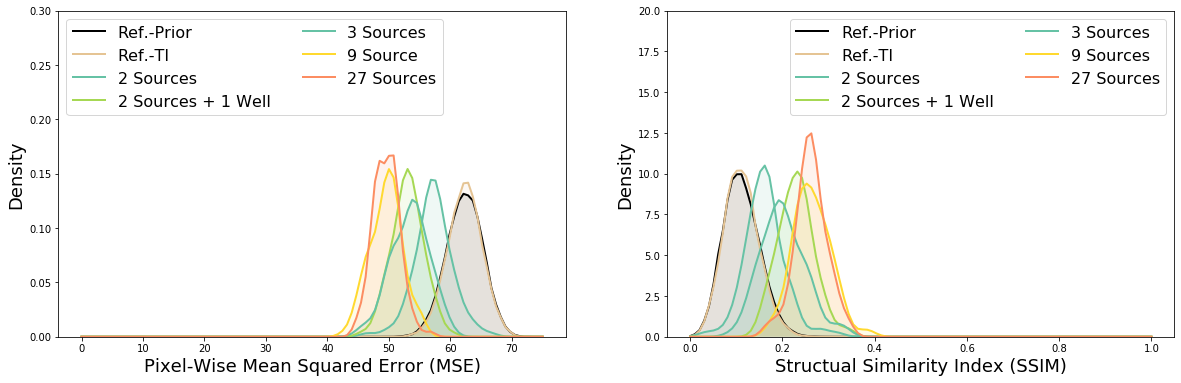

In [29]:
grid_ssim = np.linspace(0, 1.0, 100)
grid_mse = np.linspace(0, 75, 100)

multiplier = 1.0

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

wmse = get_kde(mses_all)(grid_mse)
ax[0].plot(grid_mse, wmse*multiplier, color="black", lw=2, label="Ref.-Prior")
ax[0].fill_between(grid_mse, wmse*multiplier, [0.0]*len(grid_mse), where=wmse > [0.0]*len(grid_mse), facecolor="black", alpha=0.1)

for i, (mses_model, label) in enumerate(zip([mses_ref_ti, mses_2, mses_2w, mses_3, mses_9, mses_27],
                                           [ "Ref.-TI", "2 Sources", "2 Sources + 1 Well", "3 Sources", "9 Source", "27 Sources"])):
    wmse = get_kde(mses_model)(grid_mse)
    ax[0].plot(grid_mse, wmse*multiplier, lw=2, c=cs[i], label=label)
    ax[0].fill_between(grid_mse, wmse*multiplier, [0.0]*len(grid_mse), where=wmse > [0.0]*len(grid_mse), facecolor=cs[i], alpha=0.1)
ax[0].legend(ncol=2, fontsize=16, loc=2)
ax[0].set_ylim(0.0, 0.30)
ax[0].set_xlabel("Pixel-Wise Mean Squared Error (MSE)", fontsize=18)
ax[0].set_ylabel("Density", fontsize=18)

wssim = get_kde(ssims_all)(grid_ssim)
ax[1].plot(grid_ssim, wssim*multiplier, color="black", lw=2, label="Ref.-Prior")
ax[1].fill_between(grid_ssim, wssim*multiplier, [0.0]*len(grid_ssim), where=wssim > [0.0]*len(grid_ssim), facecolor="black", alpha=0.1)

for i, (ssims_model, label) in enumerate(zip([ssims_ref_ti, ssims_2, ssims_2w, ssims_3, ssims_9, ssims_27],
                                           ["Ref.-TI", "2 Sources", "2 Sources + 1 Well", "3 Sources", "9 Sources", "27 Sources"])):
    wssim = get_kde(ssims_model)(grid_ssim)
    ax[1].plot(grid_ssim, wssim*multiplier, lw=2, c=cs[i], label=label)
    ax[1].fill_between(grid_ssim, wssim*multiplier, [0.0]*len(grid_ssim), where=wssim > [0.0]*len(grid_ssim), facecolor=cs[i], alpha=0.1)
ax[1].legend(ncol=2, fontsize=16)
ax[1].set_ylim(0.0, 20)
ax[1].set_xlabel("Structual Similarity Index (SSIM)", fontsize=18)
ax[1].set_ylabel("Density", fontsize=18)

if plot:        
    fig.savefig("./results/figures/kde_posterior_similarity.png", bbox_inches="tight", dpi=300)

Highest SSIM prior: 0.343
Lowest MSE prior: 51.942
Highest SSIM sources 27: 0.345
Lowest MSE sources 27: 44.777


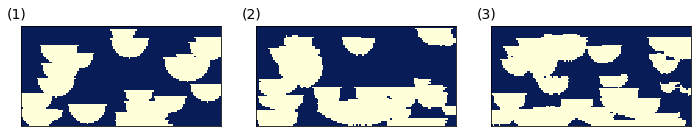

In [30]:
fig, axarr = plt.subplots(1, 3, figsize=(12, 12))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.175, hspace=-0.75)

for label, ax in zip(["(1)", "(2)", "(3)", "(4)", "(5)", "(6)"], axarr.flatten()):
    ax.set_title(label, fontsize=14, loc="left", x=-0.07, y=1.03)

axarr[0].imshow(models_ssims_ref_ti, cmap="YlGnBu_r")
axarr[1].imshow(mse_model, cmap="YlGnBu_r")
axarr[2].imshow(model_mses_27, cmap="YlGnBu_r")

print("Highest SSIM prior: %1.3f" % highest_ssim)
print("Lowest MSE prior: %1.3f" % lowest_mse)

print("Highest SSIM sources 27: %1.3f" % ssims_27[argmax_ssims_27])
print("Lowest MSE sources 27: %1.3f" % mses_27[argmin_mses_27])

for ax in axarr.flatten():
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
if plot:        
    fig.savefig("./results/figures/models_posterior_similarity_max_ssim.png", bbox_inches="tight", dpi=300)

Highest SSIM prior: 0.343
Lowest MSE prior: 51.942
Highest SSIM sources 27: 0.345
Lowest MSE sources 27: 44.777


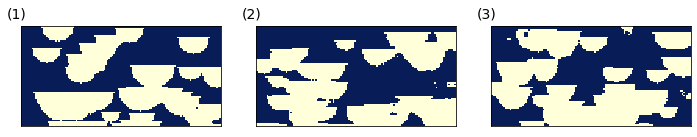

In [31]:
fig, axarr = plt.subplots(1, 3, figsize=(12, 12))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.175, hspace=-0.75)

for label, ax in zip(["(1)", "(2)", "(3)", "(4)", "(5)", "(6)"], axarr.flatten()):
    ax.set_title(label, fontsize=14, loc="left", x=-0.07, y=1.03)

axarr[0].imshow(mean_ssims_ref_ti, cmap="YlGnBu_r")
axarr[1].imshow(mean_prior_model, cmap="YlGnBu_r")
axarr[2].imshow(mean_model_mses_27, cmap="YlGnBu_r")

print("Highest SSIM prior: %1.3f" % highest_ssim)
print("Lowest MSE prior: %1.3f" % lowest_mse)

print("Highest SSIM sources 27: %1.3f" % ssims_27[argmax_ssims_27])
print("Lowest MSE sources 27: %1.3f" % mses_27[argmin_mses_27])

for ax in axarr.flatten():
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
if plot:        
    fig.savefig("./results/figures/models_posterior_similarity_mean.png", bbox_inches="tight", dpi=300)

## Other reference models inferred

In [32]:
#losses_9_1, imgs_9_1, vps_9_1, error_bars_9_1, means_9_1 = load_data("results_9_sources_model_1")
#losses_9_2, imgs_9_2, vps_9_2, error_bars_9_2, means_9_2 = load_data("results_9_sources_model_2")

In [33]:
"""x_gt1 = torch.from_numpy(test_set[1]).float().unsqueeze(0)
_, x_geo_gt1 = half_channel_test(x_gt1)
x_gt_img1 = tn(x_geo_gt1)[0][0]

x_gt2 = torch.from_numpy(test_set[2]).float().unsqueeze(0)
_, x_geo_gt2 = half_channel_test(x_gt2)
x_gt_img2 = tn(x_geo_gt2)[0][0]


fig, axarr = plt.subplots(2, 2, figsize=(12, 12))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.175, hspace=-0.8)
for error_bar, ax, title, shots, wells, prior, gt in zip([error_bars_9_1, error_bars_9_2, means_9_1, means_9_2], 
                         axarr.flatten(),
                        ["1)", "2)", "3)", "4)", "5)", "6)"], [2, 2, 2, 3, 9, 27],
                        [None, None, 64, None, None, None], [True, False, False, False, False, False],
                                                        [x_gt_img1, x_gt_img2, x_gt_img1, x_gt_img2]):
    
    cax1 = ax.imshow(error_bar, vmin=0.0, vmax=0.5, cmap="Greys_r")
    
    ax.set_title(title, fontsize=14, loc="left", x=-0.07, y=1.03)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.contour(gt, colors="r", linewidths=(0.1, ), alpha=0.25)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("top", size="10%", pad=0.01)
    if prior:
        cax.scatter(np.linspace(2, 126, shots), np.zeros((shots)), s=25, c='red', marker='D', alpha=0.0)
    else:
        cax.scatter(np.linspace(2, 126, shots), np.zeros((shots)), s=25, c='red', marker='D', alpha=0.9)
    cax.set_axis_off()
    cax.set_xlim(-1, 129)
    if wells is not None:
        cax.scatter(wells, 0, s=25, c='blue', marker='o', alpha=0.9)
    else:
        cax.scatter(wells, 0, s=25, c='blue', marker='o', alpha=0.9)
        
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.385, 0.025, 0.225])
fig.colorbar(cax1, cax=cbar_ax)
#fig.savefig("./results/figures/error_bars.png", bbox_inches="tight", dpi=300)"""

'x_gt1 = torch.from_numpy(test_set[1]).float().unsqueeze(0)\n_, x_geo_gt1 = half_channel_test(x_gt1)\nx_gt_img1 = tn(x_geo_gt1)[0][0]\n\nx_gt2 = torch.from_numpy(test_set[2]).float().unsqueeze(0)\n_, x_geo_gt2 = half_channel_test(x_gt2)\nx_gt_img2 = tn(x_geo_gt2)[0][0]\n\n\nfig, axarr = plt.subplots(2, 2, figsize=(12, 12))\nfig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.175, hspace=-0.8)\nfor error_bar, ax, title, shots, wells, prior, gt in zip([error_bars_9_1, error_bars_9_2, means_9_1, means_9_2], \n                         axarr.flatten(),\n                        ["1)", "2)", "3)", "4)", "5)", "6)"], [2, 2, 2, 3, 9, 27],\n                        [None, None, 64, None, None, None], [True, False, False, False, False, False],\n                                                        [x_gt_img1, x_gt_img2, x_gt_img1, x_gt_img2]):\n    \n    cax1 = ax.imshow(error_bar, vmin=0.0, vmax=0.5, cmap="Greys_r")\n    \n    ax.set_title(title, fontsize=14, loc="left", 